In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pgeocode
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

In [2]:
sold = pd.read_csv("C:/Users/44756/Documents/Postgrad/DSA8030/Data/sold_treated.csv", dtype = {'brokered_by':'string', 'street':'string', 'zip_code':'string'}, parse_dates = ['prev_sold_date'])

In [3]:
# Add lat/long columns based on zip code
nomi = pgeocode.Nominatim('us')
location_data = nomi.query_postal_code(sold['zip_code'].tolist())
sold['latzip'] = location_data['latitude'].values
sold['longzip'] = location_data['longitude'].values

In [4]:
# One hot encode state column
sold_dummy = pd.get_dummies(sold['state']).astype('int')
# enc = OneHotEncoder(sparse_output=False).astype('int')
# col = sold[['state']]
# enc_col = enc.fit_transform(col)
# state_df = pd.DataFrame(enc_col)
sold = pd.concat([sold, sold_dummy], axis = 1)

In [5]:
# Frequency encode city, street and broker
sold['cityfreq'] = sold['city'].map(sold['city'].value_counts())
sold['streetfreq'] = sold['street'].map(sold['street'].value_counts())
sold['brokerfreq'] = sold['brokered_by'].map(sold['brokered_by'].value_counts())

In [6]:
# Log transform target variable
sold['logprice'] = np.log(sold.price)

In [7]:
# Split train/val and test before modelling
sold_train, sold_test = train_test_split(sold, test_size = 0.2, random_state=1)

In [ ]:
def build_model(model_type, cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'], rand_state=1):
    X = sold_train[cols]
    y = sold_train['price']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=rand_state)

    model = model_type
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    resids = y_val - y_val_pred
    print('R^2', model.score(X_val, y_val))
    print('RMSE', root_mean_squared_error(y_val, y_val_pred))
    print('MAE', mean_absolute_error(y_val, y_val_pred))
    print('Positive residuals:', len(resids[resids > 0]))
    print('Negative residuals:', len(resids[resids < 0]))
    print('Average positive residual:', np.mean(resids[resids > 0]))
    print('Average negative residual:', np.mean(resids[resids < 0]))
    plt.scatter(y_val, y_val_pred, s = 0.01)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    return model, X

In [ ]:
def build_model_log(model_type, cols = ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'], rand_state=1):
    X = sold_train[cols]
    y = sold_train['logprice']

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=rand_state)

    model = model_type
    model.fit(X_train, y_train)

    y_val_pred = model.predict(X_val)
    y_val_pred_exp = np.exp(y_val_pred)
    y_val_exp = np.exp(y_val)
    print('R^2', model.score(X_val, y_val))
    print('RMSE', root_mean_squared_error(y_val_exp, y_val_pred_exp))
    print('MAE', mean_absolute_error(y_val_exp, y_val_pred_exp))
    plt.scatter(y_val_exp, y_val_pred_exp, s = 0.01)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    return model, X

Linear Regression (main dataset variables only)

R^2 0.4594368454723302
RMSE 363049.3468927382
MAE 212114.25748569053
Positive residuals: 71480
Negative residuals: 89544
Average positive residual: 238290.45205349792
Average negative residual: -191218.67109568263
Average absolute residual: 212114.25748569053


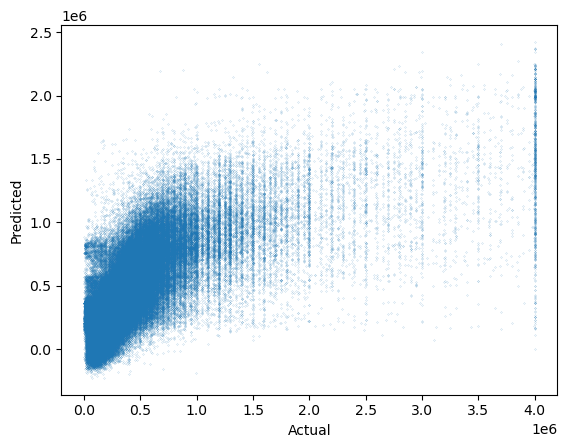

In [29]:
model, X = build_model(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [30]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model.feature_names_in_, 'coeff':model.coef_, 'abs_coeff':abs(model.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

,feature,coeff,abs_coeff
52,Utah,688827.955861,688827.955861
16,District of Columbia,501624.858395,501624.858395
29,Massachusetts,473801.522492,473801.522492
40,New York,366246.150791,366246.150791
51,Texas,-351644.071873,351644.071873
26,Louisiana,-326902.200670,326902.200670
39,New Mexico,-316102.678168,316102.678168
37,New Hampshire,302871.883854,302871.883854
32,Mississippi,-296670.936006,296670.936006
47,Rhode Island,286094.019161,286094.019161


Linear Regression Model (baseline + climate variables)

R^2 0.4944943487438648
RMSE 351079.48063936684
MAE 205990.10762577198
Positive residuals: 71924
Negative residuals: 89100
Average positive residual: 230338.4166504883
Average negative residual: -186335.4748727563
Average absolute residual: 205990.10762577198


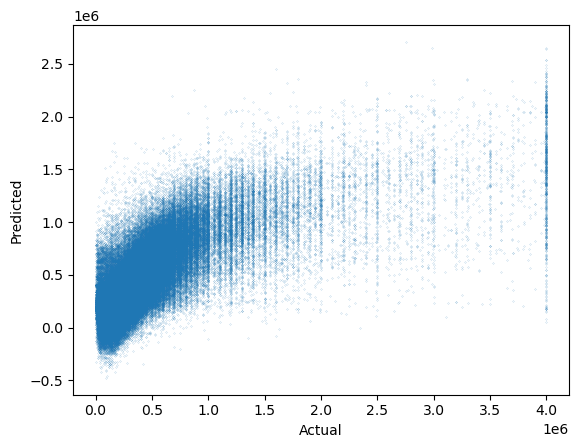

In [31]:
model, X = build_model(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [32]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model.feature_names_in_, 'coeff':model.coef_, 'abs_coeff':abs(model.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')

,feature,coeff,abs_coeff
23,Hawaii,-794961.300366,794961.300366
56,Utah,553614.797995,553614.797995
20,District of Columbia,521516.707292,521516.707292
33,Massachusetts,477130.087384,477130.087384
30,Louisiana,-353976.171579,353976.171579
55,Texas,-347990.024334,347990.024334
62,Wyoming,-332980.015592,332980.015592
41,New Hampshire,321137.446183,321137.446183
44,New York,262832.612529,262832.612529
57,Vermont,258902.750562,258902.750562


Linear Regression Model (baseline + facilities/demographic variables)

R^2 0.6019764479739904
RMSE 311527.8122556024
MAE 184611.40803146255
Positive residuals: 76237
Negative residuals: 84787
Average positive residual: 194735.97545589565
Average negative residual: -175507.8114100878
Average absolute residual: 184611.40803146255


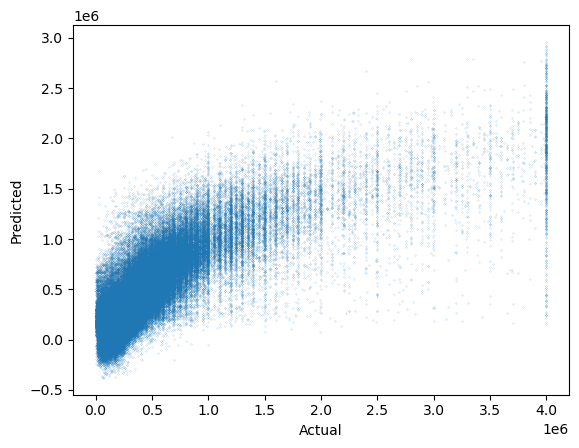

In [33]:
model, X = build_model(LinearRegression(),['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

In [34]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model.feature_names_in_, 'coeff':model.coef_, 'abs_coeff':abs(model.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')

,feature,coeff,abs_coeff
63,Utah,460923.003443,460923.003443
40,Massachusetts,427254.604411,427254.604411
48,New Hampshire,340025.209984,340025.209984
62,Texas,-318670.536857,318670.536857
64,Vermont,301096.988501,301096.988501
21,Arizona,-276653.471085,276653.471085
51,New York,274220.720977,274220.720977
58,Rhode Island,273964.399499,273964.399499
69,Wyoming,-261673.709049,261673.709049
25,Connecticut,253527.975983,253527.975983


Linear Regression Model (all variables)

R^2 0.6066273720311042
RMSE 309702.355327632
MAE 182449.0914626042
Positive residuals: 76482
Negative residuals: 84542
Average positive residual: 192039.44173370473
Average negative residual: -173773.05860988822
Average absolute residual: 182449.0914626042


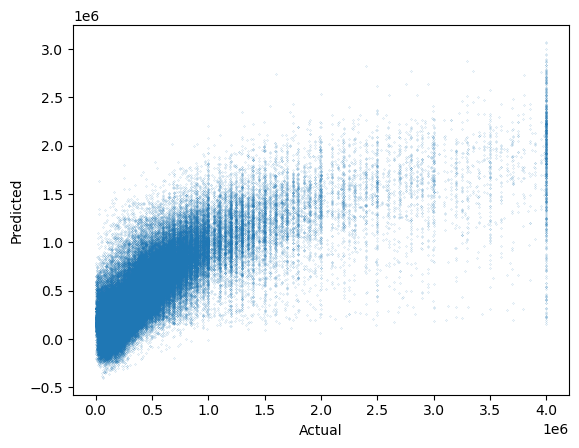

In [35]:
model, X = build_model(LinearRegression())

In [36]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
display(pd.DataFrame({'feature':model.feature_names_in_, 'coeff':model.coef_, 'abs_coeff':abs(model.coef_)}).sort_values('abs_coeff', ascending = False))
pd.reset_option('display.max_columns')

,feature,coeff,abs_coeff
44,Massachusetts,403850.902043,403850.902043
34,Hawaii,-356880.864981,356880.864981
73,Wyoming,-346117.384874,346117.384874
67,Utah,342029.172136,342029.172136
52,New Hampshire,301386.228456,301386.228456
66,Texas,-293625.231608,293625.231608
31,District of Columbia,256926.634107,256926.634107
62,Rhode Island,239857.383766,239857.383766
68,Vermont,232021.038293,232021.038293
29,Connecticut,231672.938433,231672.938433


XGBoost (all variables, default parameters)

R^2 0.8291569183389692
RMSE 204099.12271183284
MAE 104614.58455939015
Positive residuals: 74547
Negative residuals: 86477
Average positive residual: 113273.04198685489
Average negative residual: -97150.61118097491
Average absolute residual: 104614.58455939015


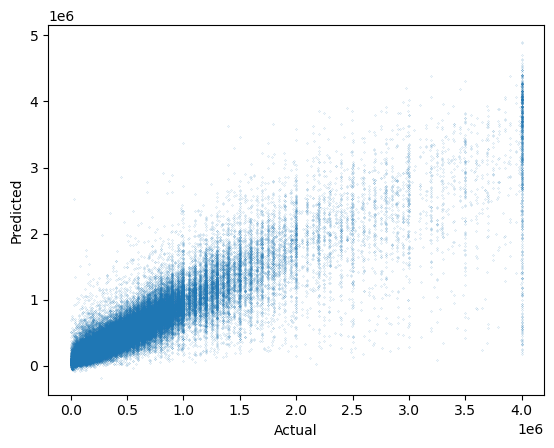

In [37]:
model, X = build_model(xgb.XGBRegressor(eval_metric=['mae', 'rmse']))

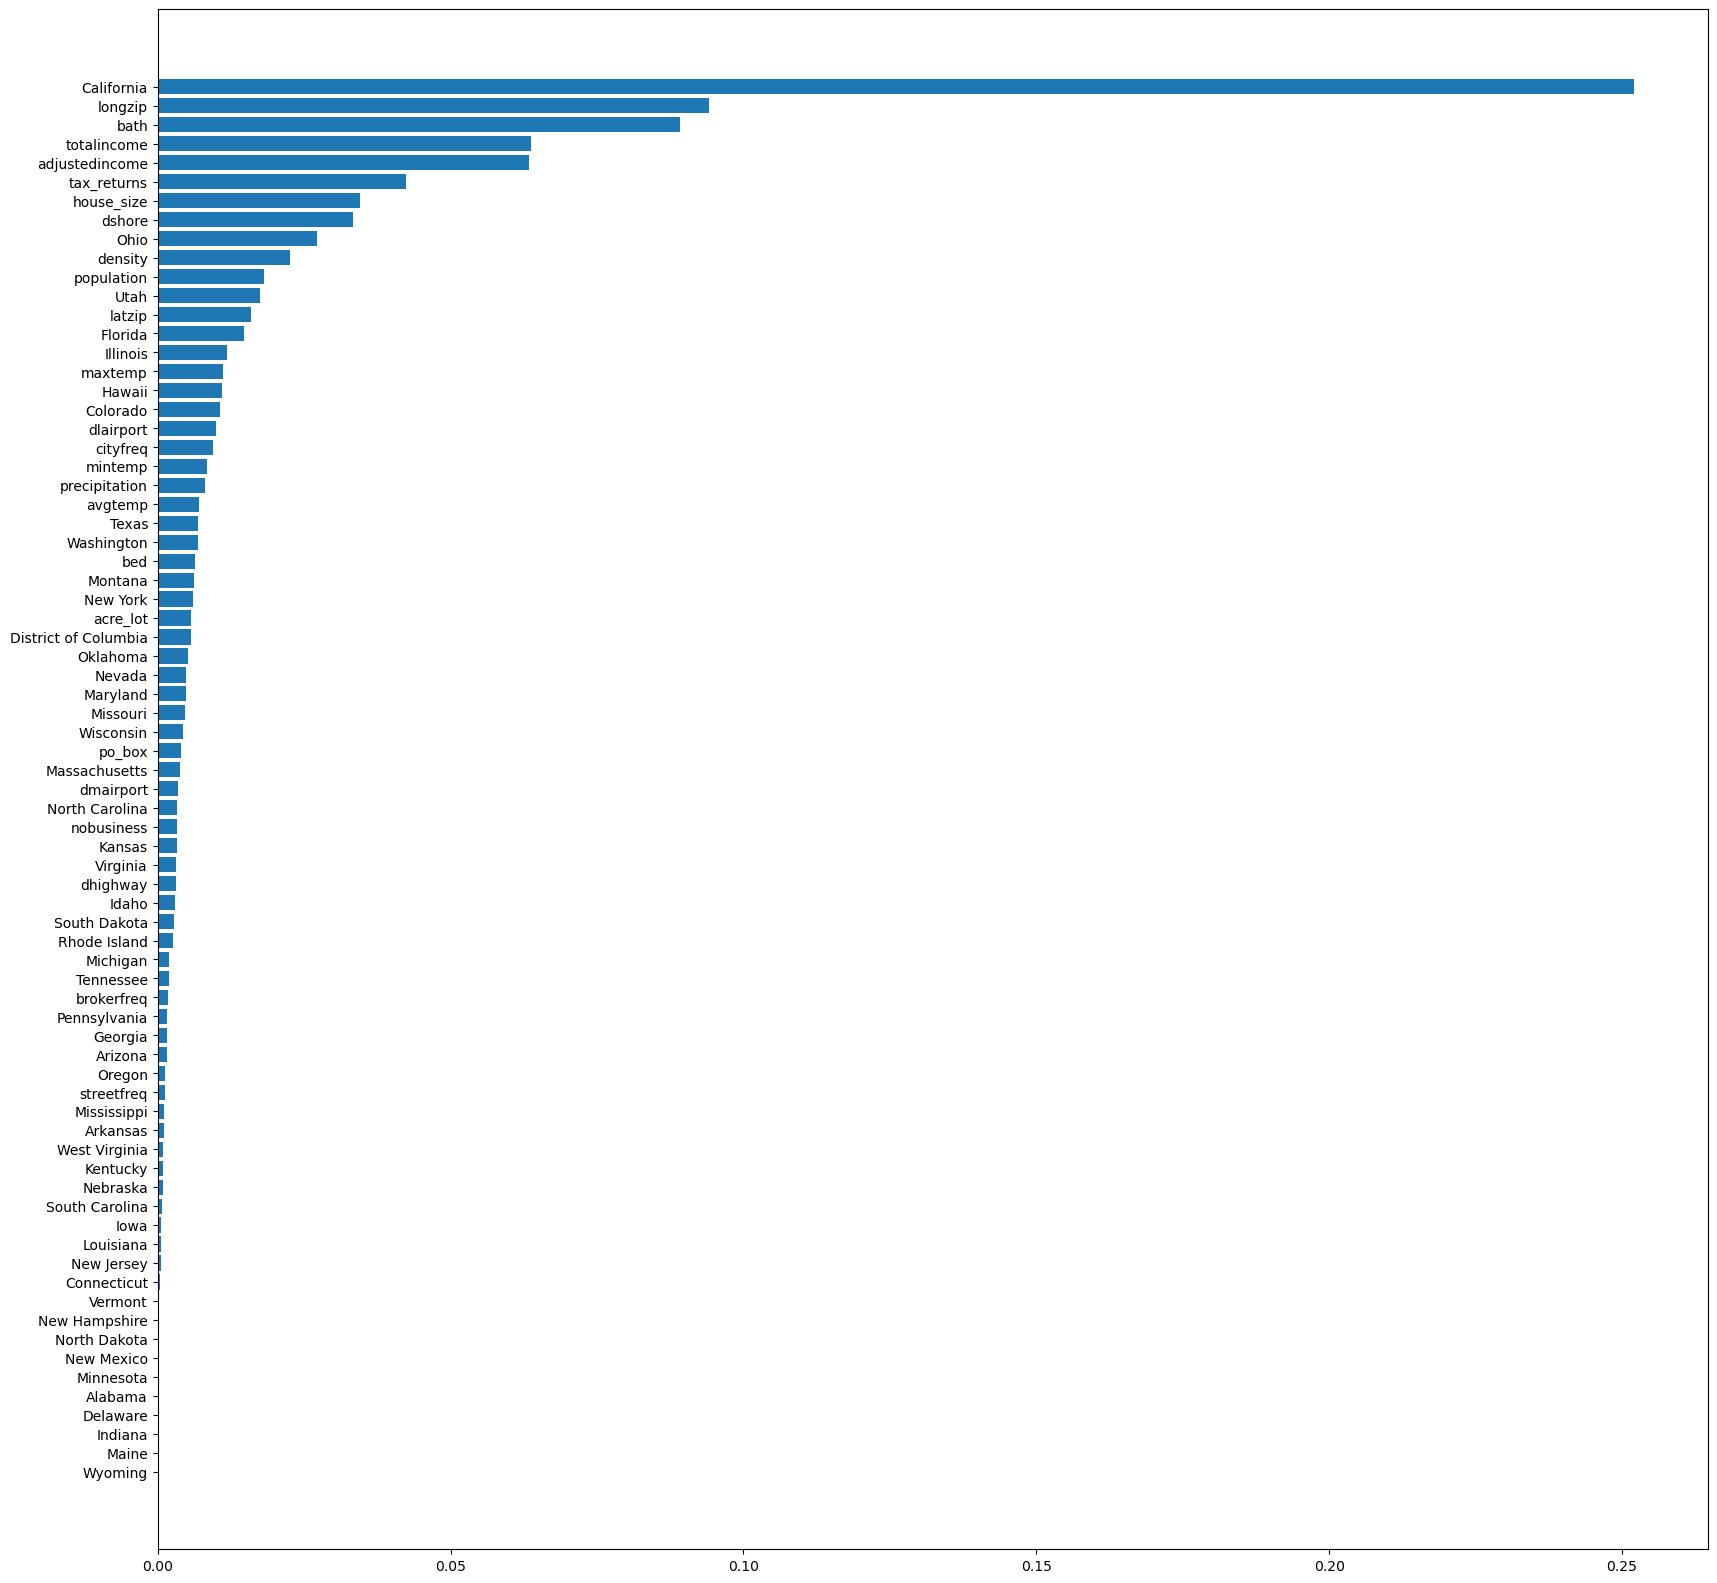

In [38]:
sorted_idx = model.feature_importances_.argsort()
plt.figure(figsize=(20,20))
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.show()

Decision Tree Regressor (all variables, default parameters)

R^2 0.6867601334285601
RMSE 276363.6722329964
MAE 126830.94455173965
Positive residuals: 77854
Negative residuals: 79480
Average positive residual: 127843.60706051157
Average negative residual: -131727.35067199622
Average absolute residual: 126830.94455173965


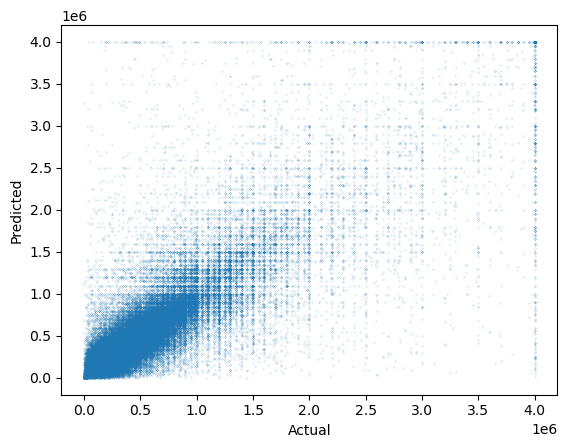

In [39]:
model, X = build_model(DecisionTreeRegressor())

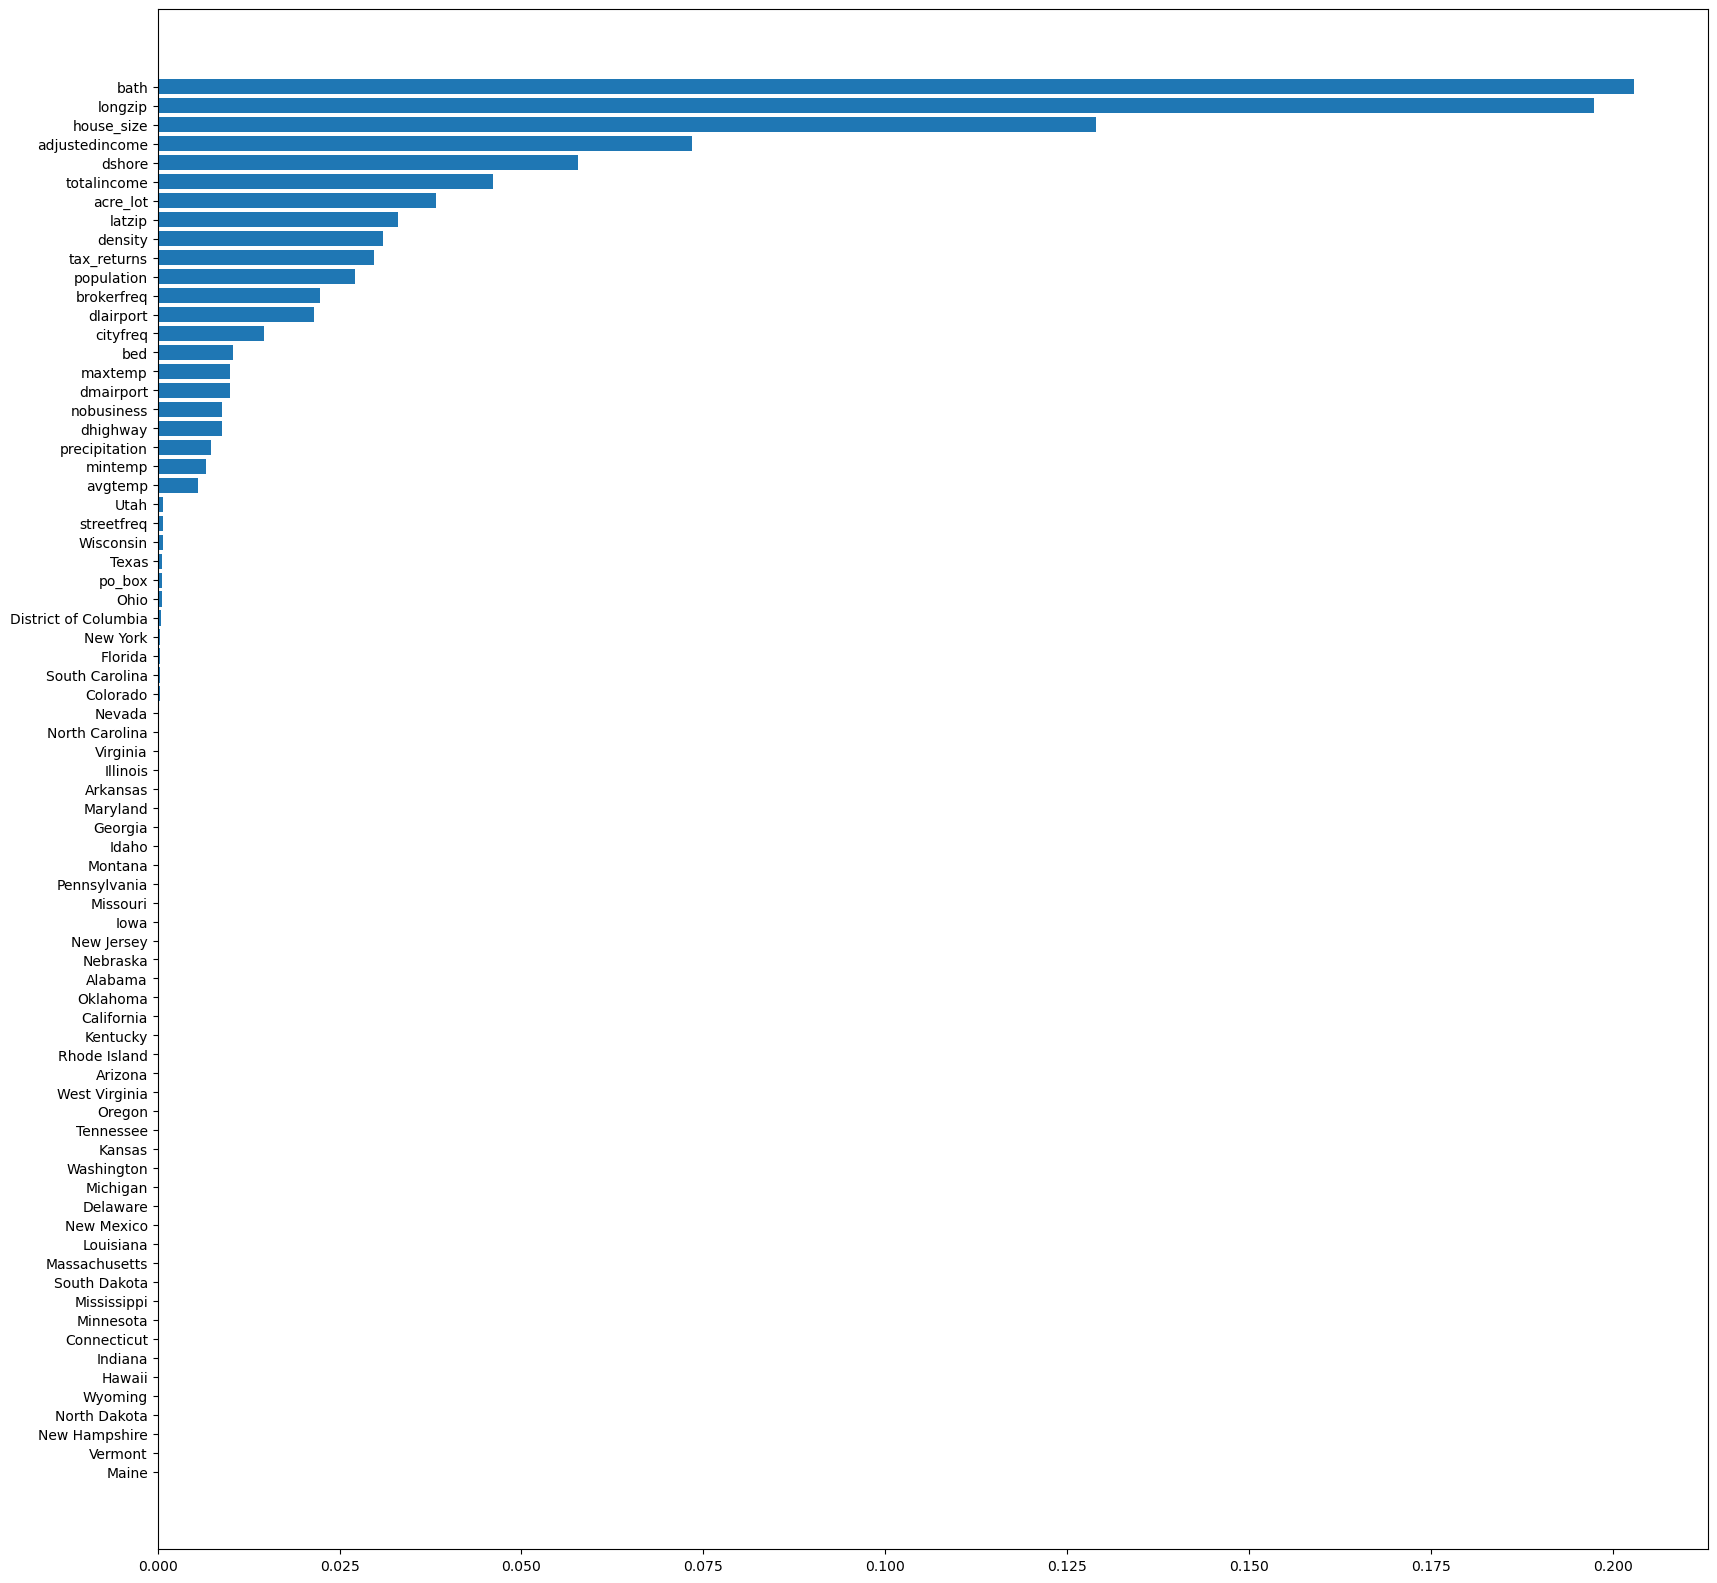

In [40]:
sorted_idx = model.tree_.compute_feature_importances().argsort()
plt.figure(figsize=(20,20))
plt.barh(X.columns[sorted_idx], model.feature_importances_[sorted_idx])
plt.show()

Random Forest Regressor (all variables, default hyperparameters)

R^2 0.836212943393317
RMSE 199839.91156200145
MAE 93320.822394525
Positive residuals: 72500
Negative residuals: 88471
Average positive residual: 100059.09713686895
Average negative residual: -87854.86275540003
Average absolute residual: 93320.822394525


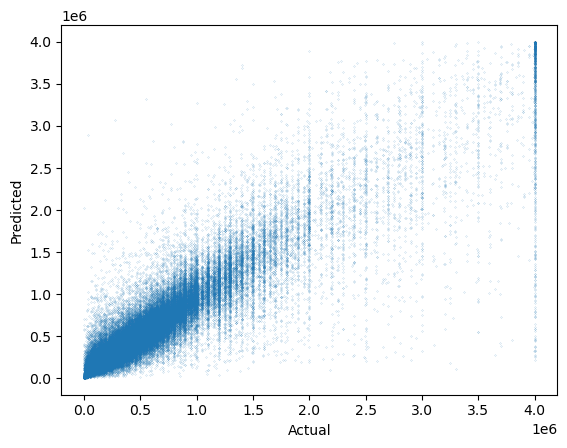

In [41]:
model, X = build_model(RandomForestRegressor())

SVM (all variables, default hyperparameters)

c:\Users\44756\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


R^2 0.3360241920093787
RMSE 402363.49117137486
MAE 242587.5562279942


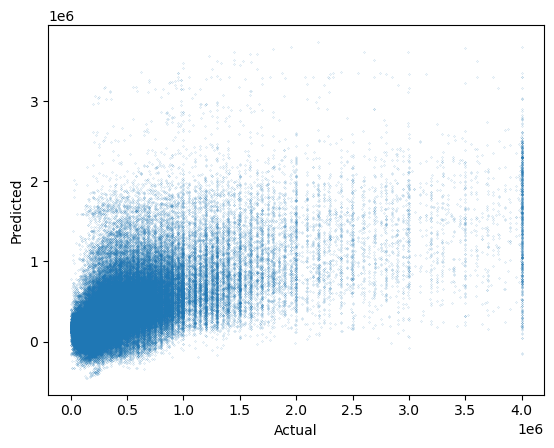

In [8]:
model, X = build_model(LinearSVR())

Linear Regression (main variables only, log price)

R^2 0.4501950982591425
RMSE 360905.48570894153
MAE 185929.28176297998


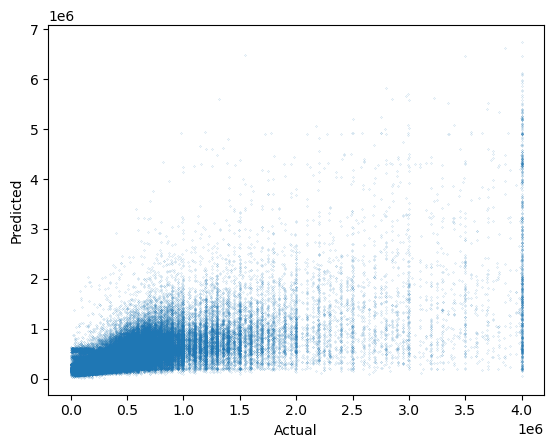

In [15]:
model, X = build_model_log(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

Linear Regression (main + climate variables only, log price)

R^2 0.47583796821602264
RMSE 350509.32700821484
MAE 177925.8625110473


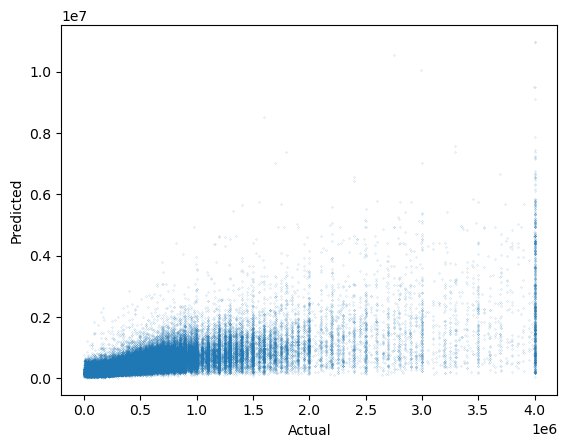

In [16]:
model, X = build_model_log(LinearRegression(), ['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'precipitation', 'maxtemp', 'mintemp', 'avgtemp', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

Linear Regression (main + facilities/demo variables, log price)

R^2 0.5532137318722673
RMSE 340271.19311821746
MAE 161224.38773978184


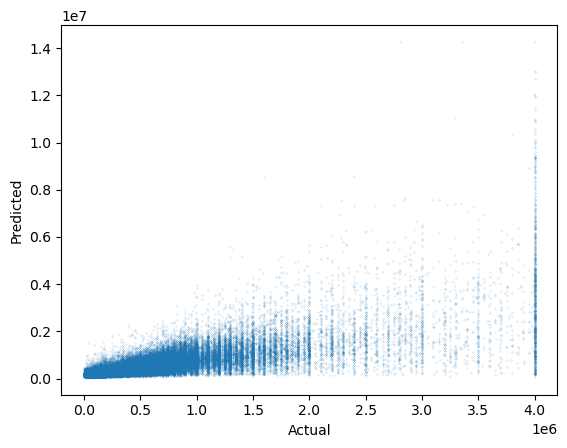

In [17]:
model, X = build_model_log(LinearRegression(),['bed', 'bath', 'acre_lot', 'house_size', 'latzip', 'longzip', 'cityfreq', 'streetfreq', 'brokerfreq', 'po_box', 'population', 'density', 'dhighway', 'dlairport', 'dmairport', 'dshore', 'nobusiness', 'totalincome', 'adjustedincome', 'tax_returns', 'Alabama', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'])

Linear Regression (all vars, log price)

R^2 0.5552311866620578
RMSE 343552.568302323
MAE 160968.68563215638


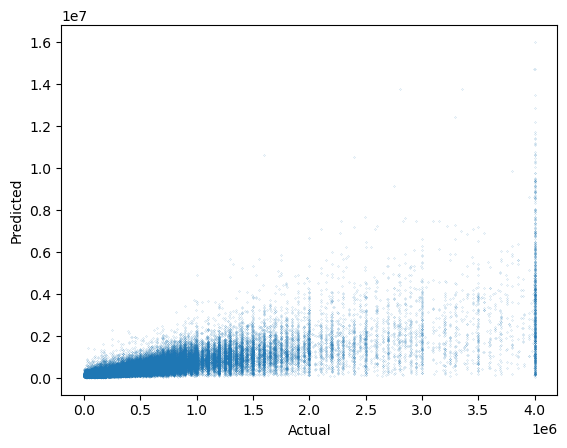

In [23]:
model, X = build_model_log(LinearRegression())

XGBoost (all vars, default hyper, log price)

R^2 0.7950090519640406
RMSE 218115.32375232005
MAE 103633.82595172903


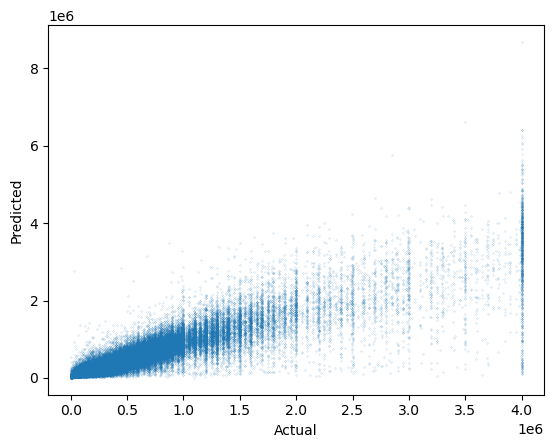

In [19]:
model, X = build_model_log(xgb.XGBRegressor(eval_metric=['mae', 'rmse']))

Decision Tree Regressor (all vars, default hyper, log price)

R^2 0.6586510146540003
RMSE 273612.09561880317
MAE 126368.22979911744


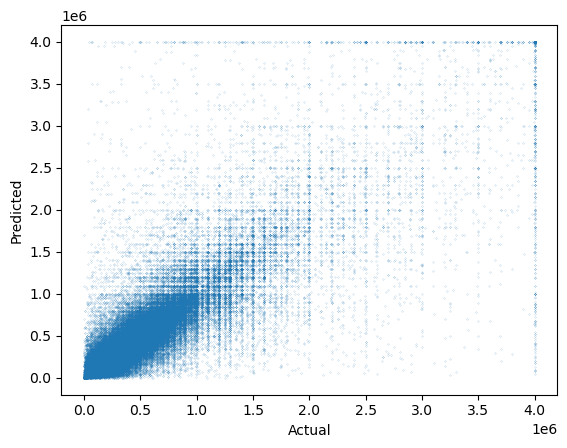

In [25]:
model, X = build_model_log(DecisionTreeRegressor())

Random Forest Regressor (all vars, default hyper, log price)

R^2 0.8206374315919891
RMSE 201308.9259197484
MAE 90275.9730448763


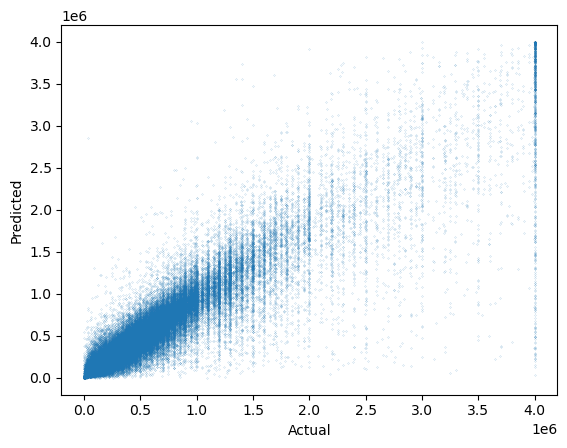

In [26]:
model, X = build_model_log(RandomForestRegressor())

SVG (all variables, default hyper, log price)

c:\Users\44756\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


R^2 -12.009300425404959
RMSE 7165799046160.989
MAE 214290606160.12494


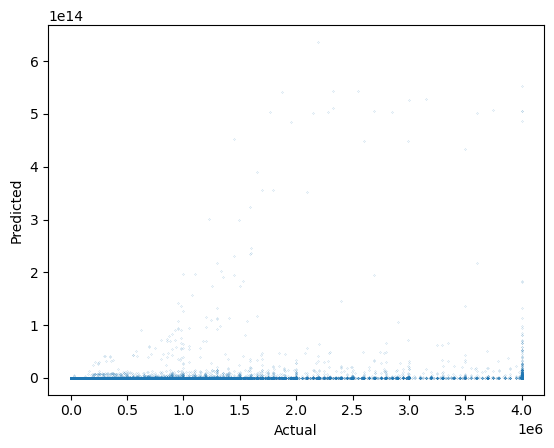

In [27]:
model, X = build_model_log(LinearSVR())